## Data preparation

In [1]:
from codes import data as d
import numpy as np

In [2]:
# Scenario: customers come to an e-commerce website only for 3 purposes
# (ex: buying gifts for girlfriend, for Dad, for children)
# with weights being 2:1:3
fd = d.FakeData([2,1,3])

# There are 4 groups of products on the website
# The first group has 50 items and it only serves the purpose for girlfriend's gift 
# (That is, No one will buys items in this group for Dad or children)
fd.add_group([1,0,0],50)
fd.add_group([0,1,0],50)
fd.add_group([0,0,1],50)
fd.add_group([1,1,1],50)

fd.get_ready()

In [3]:
# When a cutomer looks for gift for girlfriend, 
# he will spend 75% of the time browsing items in group 1, 
# 0% of the time in group 2 and 3, and 25% og the timein group 4
fd.group_prob_by_intention

[[0.75, 0.0, 0.0, 0.25], [0.0, 0.75, 0.0, 0.25], [0.0, 0.0, 0.75, 0.25]]

In [4]:
# Generating pairs of items that often be browsed together
item_pairs = fd.generate_pairs(10000)
item1_list, item2_list = list(zip(*item_pairs))

# convert to the format for feeding into the model
data_num = len(item1_list)
item1_list = np.array(item1_list).reshape(data_num,1)
item2_list = np.array(item2_list).reshape(data_num,1)
output = np.zeros((data_num,1))

## Training

In [7]:
from codes import model as m
import keras
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


In [68]:
item_num = fd.sizes[-1] # num of total items
embedding_size = 3
model = m.get_model(item_num,embedding_size)

In [69]:
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_10 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
item_embedding (Embedding)      (None, 1, 3)         600         input_9[0][0]                    
                                                                 input_10[0][0]                   
__________________________________________________________________________________________________
lambda_5 (Lambda)               (None, 1)            0           item_embedding[0][0]       

In [70]:
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mse')

In [73]:
batch_size = 512
no_epochs = 500
validation_split = 0.2

checkpoint = ModelCheckpoint(
    "models/best_model.hdf5", monitor='val_loss', verbose=0, save_best_only=True, mode='auto', period=1
)

# start training
history = model.fit(
    [item1_list,item2_list], output, 
    epochs = no_epochs, batch_size = batch_size, verbose=0, 
    validation_split = validation_split, callbacks=[checkpoint]
)

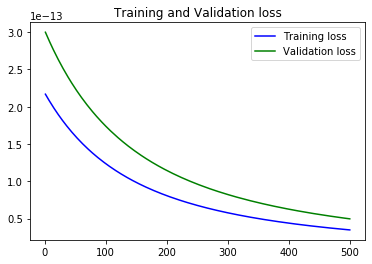

In [74]:
import matplotlib.pyplot as plt

# visualization of training and validation loss 
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'g', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

## Embedding visualization

In [65]:
from sklearn.manifold import TSNE

In [75]:
item_embed = model.get_layer("item_embedding").get_weights()[0]
item_embed = TSNE(n_components=2).fit_transform(item_embed)

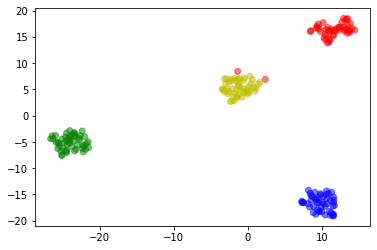

In [76]:
# Items belonging to different groups are seperated as expected
# It also makes sense that group 4 (yellow) lies in the middle, surrounded by the other three groups
x, y = zip(*item_embed) 
item_color = fd.get_color_list(['r','b','g','y'])
plt.scatter(x,y,c=item_color,alpha=0.5)